# Stanford CME 241 (Winter 2024) - Assignment 5

**Due: Feb 12 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve any 3 of the 4 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/sanj909/cme241/blob/master/assignments/assignment5.ipynb

*Group members (replace below names with people in your group):* 
- Sanjit Neelam
- Ryan Padnis

## Imports

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson, normal
from typing import Sequence, Tuple, Iterator

from rl.approximate_dynamic_programming import back_opt_vf_and_policy, ValueFunctionApprox
from rl.chapter9.optimal_order_execution import OptimalOrderExecution, PriceAndShares
from rl.chapter9.order_book import OrderBook, DollarsAndShares
from rl.distribution import Bernoulli, Constant, Distribution, Gaussian, SampledDistribution
from rl.function_approx import FunctionApprox, LinearFunctionApprox
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import MarkovProcess, State, NonTerminal
from rl.policy import DeterministicPolicy

## Question 1
You are a milkvendor and your task is to bring to your store a supply
(denoted $S \in \mathbb{R}$) of milk volume in the morning that will
give you the best profits. You know that the demand for milk through the
course of the day is a probability distribution function $f$ (for
mathematical convenience, assume people can buy milk in volumes that are
real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous
variable with a probability density function). For every extra gallon of
milk you carry at the end of the day (supply $S$ exceeds random demand
$x$), you incur a cost of $h$ (effectively the wasteful purchases
amounting to the difference between your purchase price and end-of-day
discount disposal price since you are not allowed to sell the same milk
the next day). For every gallon of milk that a customer demands that you
don't carry (random demand $x$ exceeds supply $S$), you incur a cost of
$p$ (effectively the missed sales revenue amounting to the difference
between your sales price and purchase price). So your task is to
identify the optimal supply $S$ that minimizes your Expected Cost
$g(S)$, given by the following:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

After you solve this problem, see if you can frame this problem in terms
of a call/put options portfolio problem.

- Our goal is to minimize the Expected Cost $g(S) = p \int_S^{\infty} (x-S) \cdot f(x) \cdot dx + h \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$ with respect to $S$, so we are going to take a derivative w.r.t $S$, and use the Fundamental Theorem of Calculus to eliminate the integral. We have
\begin{align*}
    \frac{d}{dS} g(S) &= \frac{d}{dS} \left(p \int_S^{\infty} (x-S) \cdot f(x) \cdot dx + h \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx \right) \\
    &= p \frac{d}{dS} \int_S^{\infty} (x-S) \cdot f(x) \cdot dx + h \frac{d}{dS} \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx \\
    &= p \frac{d}{dS} \left( \int_S^{\infty} x f(x) dx - S\int_S^{\infty} f(x) dx \right) + h \frac{d}{dS} \left( S\int_{-\infty}^S f(x) dx - \int_{-\infty}^S xf(x) dx \right) \\
    &= - p \left( \int^{\infty}_S f(x) dx \right) + h \left(\int_{-\infty}^S f(x) dx \right)
\end{align*}
using the product rule and FTC. 
- Then via our minimization condition, we set this last expression equal to zero. Now we can simplify further, and since $f(x)$ is some arbitrary pdf, it has a distribution function $F(x \le S) = \int_{-\infty}^S f(x) dx = 1 - F(x > S)$, which implies via our optimality:
\begin{align*}
    hF(x \le S) = p (1 - F(x \le S)) \implies F(x \le S) = \frac{p}{h + p}
\end{align*}
- As a result, if we let $F^{-1}$ represent the inverse cdf (i.e. quantile function of the underlying random variable $x$), then we have
\begin{align*}
    S^* = F^{-1}(\frac{p}{h + p}).
\end{align*}
- This problem is equivalent to the problem of choosing a strike price $S$ to minimize the expected cost of selling $p$ call options and $h$ put options, where all options sold have the same time to  maturity and strike price $S$. Here, $x$ represents the random price of the underlying assert at maturity.

## Question 2
[rl/chapter8/optimal_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py)
models the American Payoff pricing problem as a `FiniteMarkovDecisionProcess` in the form of a binary tree with only two
discrete transitions for any given asset price. In the world of mathematical and computational finance, it is common practice to work
with continuous-valued asset prices and transitions to a continuous set of asset prices for the next time step. Your task is to model this
problem as a `MarkovDecisionProcess` (not finite) with discrete time, continuous-valued asset prices and a continuous-set of transitions.
Assume an arbitrary probability distribution for asset price movements from one time step to another, so you'd be sampling from the arbitrary
transition probability distribution. Hence, you will be solving this problem with Approximate Dynamic Programming using the code in
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py).

## Question 3
We'd like to build a simple simulator of Order Book Dynamics as a
`MarkovProcess` using the code in
[rl/chapter9/order_book.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/order_book.py).
An object of type `OrderBook` constitutes the *State*. Your task is to
come up with a simple model for random arrivals of Market Orders and
Limit Orders based on the current contents of the `OrderBook`. This
model of random arrivals of Market Orders and Limit Orders defines the
probabilistic transitions from the current state (`OrderBook` object) to
the next state (`OrderBook` object). Implement the probabilistic
transitions as a `MarkovProcess` and use it's `simulate` method to
complete your implementation of a simple simulator of Order Book
Dynamics.

Experiment with different models for random arrivals of Market Orders
and Limit Orders.

- We experiment with two different models for random arrivals of Market Orders and Limit Orders.

In [2]:
class DynamicOrderBook(MarkovProcess[OrderBook]):
    p_limit: float
    p_buy: float

    def __init__(self, p_limit: float, p_buy: float, transition_model: int):
        self.p_limit = p_limit
        self.p_buy = p_buy
        self.transition_model = transition_model

    def transition_1(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        def next_state(state=state):
            next_is_limit: bool = Bernoulli(self.p_limit).sample()
            next_is_buy: bool = Bernoulli(self.p_buy).sample()
            
            all_prices: np.ndarray = np.concatenate((
                [x.dollars for x in state.state.descending_bids],
                [x.dollars for x in state.state.ascending_asks]
            ))
            all_quantities: np.ndarray = np.concatenate((
                [x.shares for x in state.state.descending_bids],
                [x.shares for x in state.state.ascending_asks]
            ))

            if next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_limit_order(
                    np.mean(all_prices), 
                    np.mean(all_quantities)
                )[1]
            elif next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_limit_order(
                    np.mean(all_prices), 
                    np.mean(all_quantities)
                )[1]
            elif not next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_market_order(
                    np.mean(all_quantities)
                )[1]
            elif not next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_market_order(
                    np.mean(all_quantities)
                )[1]
            
            return NonTerminal(next_st)

        return SampledDistribution(next_state)
    
    def transition_2(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        def next_state(state=state):
            next_is_limit: bool = Bernoulli(self.p_limit).sample()
            next_is_buy: bool = Bernoulli(self.p_buy).sample()

            bids = [x.dollars for x in state.state.descending_bids]
            asks = [x.dollars for x in state.state.ascending_asks]
            bids_iqr = np.percentile(bids, 75) - np.percentile(bids, 25)
            asks_iqr = np.percentile(asks, 75) - np.percentile(asks, 25)
            if max(bids) > np.percentile(bids, 75) + 1.5 * bids_iqr:
                next_is_limit = False
                next_is_buy = False
            elif min(asks) < np.percentile(asks, 25) - 1.5 * asks_iqr:
                next_is_limit = False
                next_is_buy = True
            
            bid_qs = [x.shares for x in state.state.descending_bids]
            ask_qs = [x.shares for x in state.state.ascending_asks]

            if next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_limit_order(
                    np.max(bids) + normal(0, 1),
                    poisson(np.mean(bid_qs))
                )[1]
            elif next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_limit_order(
                    np.min(asks) - normal(0, 1),
                    poisson(np.mean(ask_qs))
                )[1]
            elif not next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_market_order(
                    0.5 * poisson(np.mean(bid_qs))
                )[1]
            elif not next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_market_order(
                    0.5 * poisson(np.mean(ask_qs))
                )[1]
            
            return NonTerminal(next_st)

        return SampledDistribution(next_state)
    
    def transition(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        if self.transition_model == 1:
            return self.transition_1(state)
        elif self.transition_model == 2:
            return self.transition_2(state)

- In the first model, we assume that
    - The next order is a market order with probability `p_limit` and is a buy order with probabiity `p_buy`,
    - The price of the next limit order is the mean of the prices of all limit orders in the order book, and
    - The quantity of the next order is the mean of the prices of all limit orders in the order book.
- This is not a realistic model since e.g.
    - We can see that some buy limit orders are at a much higher price than the previous bid price and some sell limit orders are at a much lower price than the previous ask price.
    - We would ordinarily expect such limit orders to be taken advantage of immediately, but this does not happen in our model since e.g. it assumes the type of the next order is independent of the current state of the order book.
    - The bid_ask_spread appears to increase over time.
    - The quantity of the next order is determined in the same way for both limit and market orders. Intuitively, we might expect that the quantity in a limit order is on average higher than the quantit in a market order since the former is placed by a trader who is willing to wait for a good price.

Iteration 0
Bid-ask spread: 5
Market depth: 23


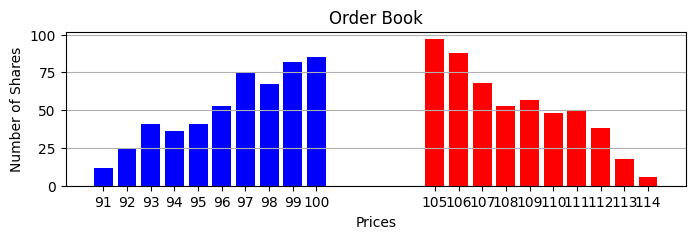

--------------------------------------------------------------------------------
Iteration 5
Bid-ask spread: 6
Market depth: 23


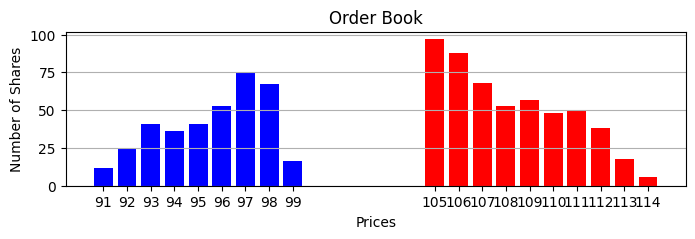

--------------------------------------------------------------------------------
Iteration 10
Bid-ask spread: 2.3684210526315894
Market depth: 23


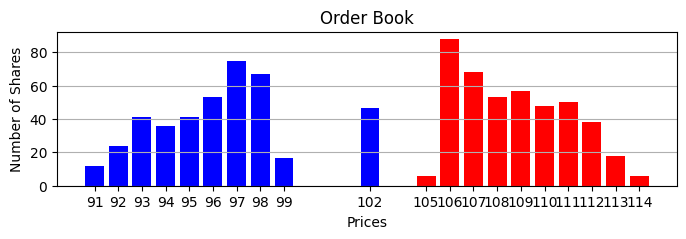

--------------------------------------------------------------------------------
Iteration 15
Bid-ask spread: 9
Market depth: 23


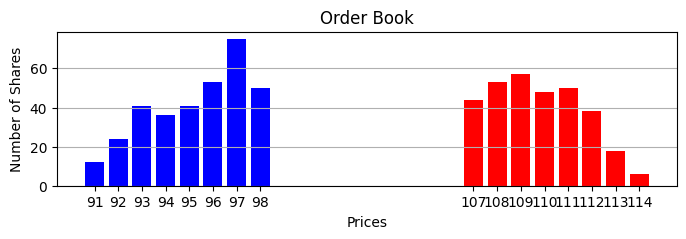

--------------------------------------------------------------------------------
Iteration 20
Bid-ask spread: 5.799999999999997
Market depth: 23


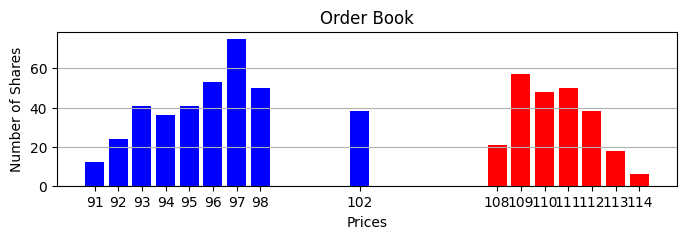

--------------------------------------------------------------------------------
Iteration 25
Bid-ask spread: 7.186666666666667
Market depth: 23


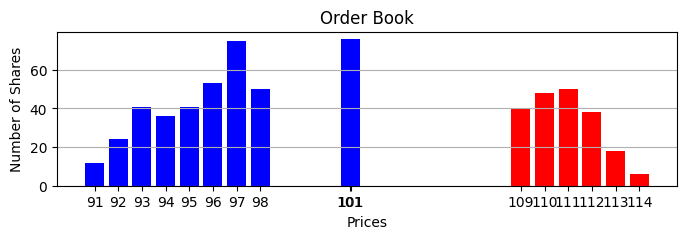

--------------------------------------------------------------------------------
Iteration 30
Bid-ask spread: 3.2705396825396917
Market depth: 23


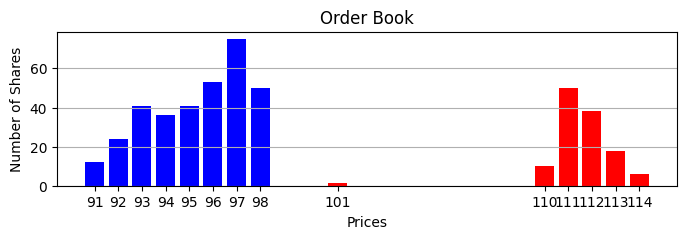

--------------------------------------------------------------------------------
Iteration 35
Bid-ask spread: 0.036929705215428044
Market depth: 23


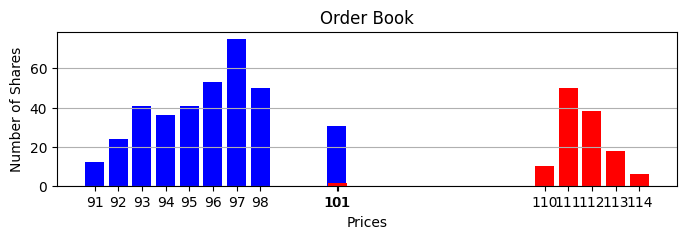

--------------------------------------------------------------------------------
Iteration 40
Bid-ask spread: 10.5
Market depth: 23


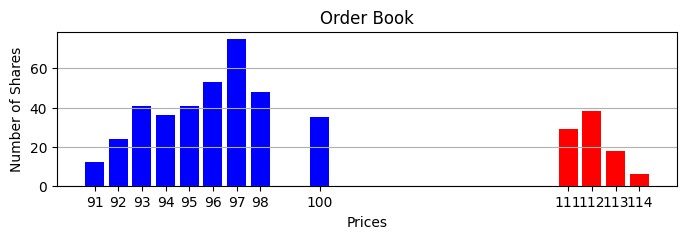

--------------------------------------------------------------------------------
Iteration 45
Bid-ask spread: 2.5
Market depth: 23


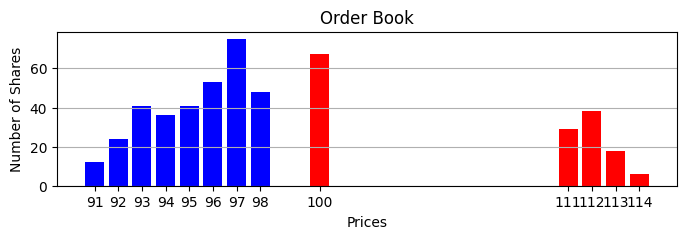

--------------------------------------------------------------------------------


In [3]:
order_book_mp: DynamicOrderBook = DynamicOrderBook(
    p_limit=0.5, 
    p_buy=0.5,
    transition_model=1
)

ob_0 = OrderBook(
    descending_bids=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (100 - x) * 10)
    ) for x in range(100, 90, -1)], 
    ascending_asks=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (x - 105) * 10)
    ) for x in range(105, 115, 1)]
)
init_ob_dist: Distribution[NonTerminal[OrderBook]] = Constant(NonTerminal(ob_0))
dynamic_order_book = order_book_mp.simulate(init_ob_dist)

MAX_ITER = 50
PRINT_INTERVAL = 5
for i in range(MAX_ITER):
    cur_ob = next(dynamic_order_book).state
    if i % PRINT_INTERVAL == 0:
        print(f'Iteration {i}')
        print(f'Bid-ask spread: {cur_ob.bid_ask_spread()}')
        print(f'Market depth: {cur_ob.market_depth()}')
        plt.figure(figsize=(8, 2))
        cur_ob.display_order_book()
        print('-' * 80)

- In the second model, we assume that
    - The next order is a market order with probability `p_limit` and is a buy order with probabiity `p_buy`, unless
        -  the best bid is an outlier (greater than 1.5 times the inter-quartile range above the third quartile), in which case the next order is a sell market order.
        - the best ask is an outlier (less than 1.5 times the inter-quartile range below the first quartile), in which case the next order is a buy market order.
    - The price of the next buy (sell) limit order is normally distributed, where the mean of the normal distribution is the max of the prices of all buy (sell) limit orders in the order book and the variance of the normal distribution is 1.
    - The quantity of the next limit order is poisson distributed, where the mean of the poisson distribution is the mean of the quantities of all limit orders in the order book.
    - The quantities of the next market order is half what the quantity of the next limit order would be.
- This model appears more realistic than the first model, since e.g.
    - We no longer observe outlier bid and ask prices.
    - The bid-ask spread no longer increases over time.

Iteration 0
Bid-ask spread: 5
Market depth: 23


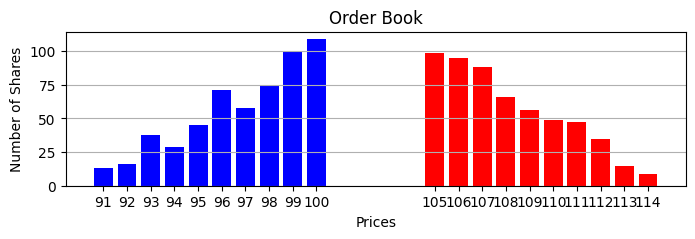

--------------------------------------------------------------------------------
Iteration 5
Bid-ask spread: 5
Market depth: 23


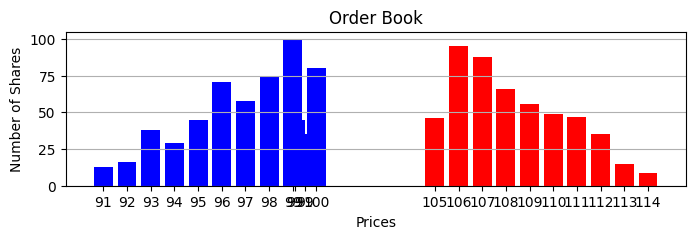

--------------------------------------------------------------------------------
Iteration 10
Bid-ask spread: 6
Market depth: 23


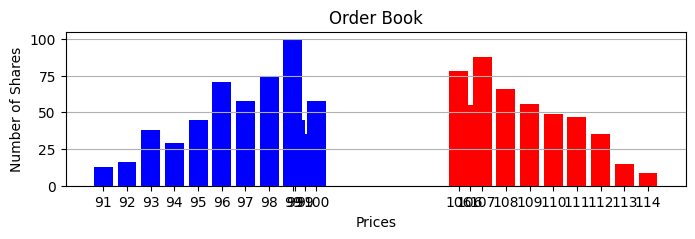

--------------------------------------------------------------------------------
Iteration 15
Bid-ask spread: 6
Market depth: 23


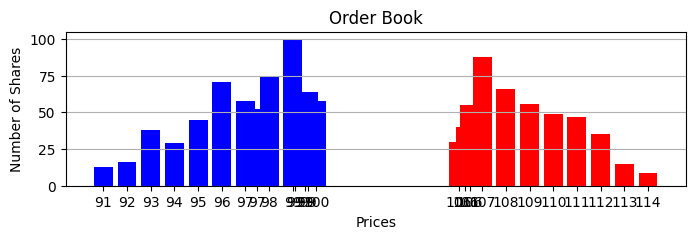

--------------------------------------------------------------------------------
Iteration 20
Bid-ask spread: 5.521678305528653
Market depth: 23


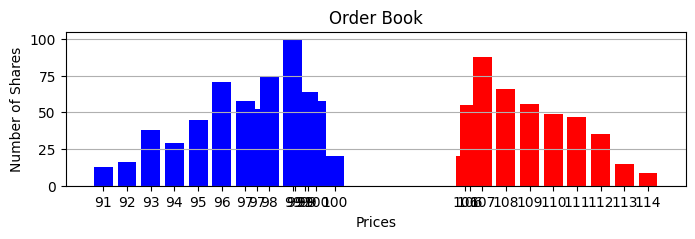

--------------------------------------------------------------------------------
Iteration 25
Bid-ask spread: 3.159037550653025
Market depth: 23


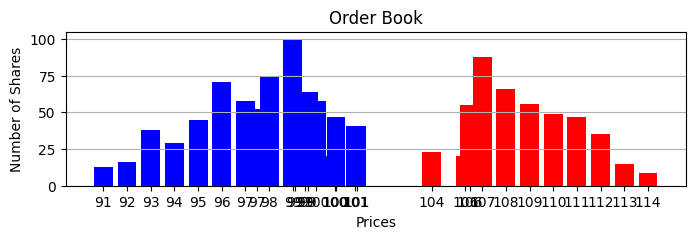

--------------------------------------------------------------------------------
Iteration 30
Bid-ask spread: 3.8526535356153886
Market depth: 23


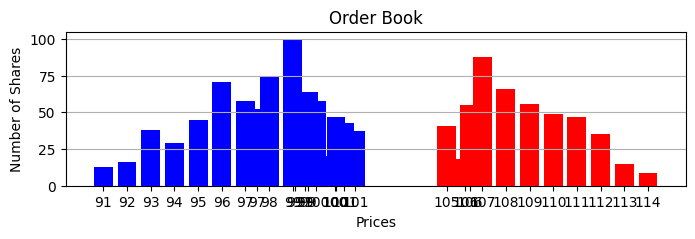

--------------------------------------------------------------------------------
Iteration 35
Bid-ask spread: 4.315384848408186
Market depth: 23


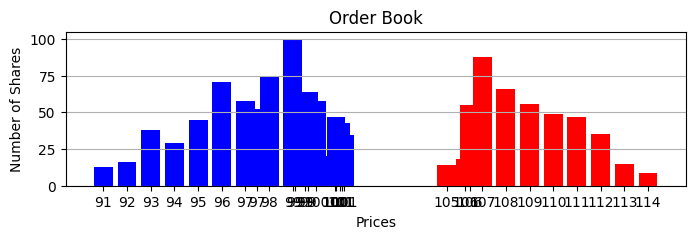

--------------------------------------------------------------------------------
Iteration 40
Bid-ask spread: 3.5982704967845365
Market depth: 23


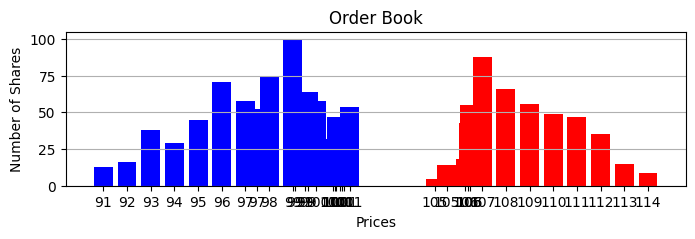

--------------------------------------------------------------------------------
Iteration 45
Bid-ask spread: 3.8668774123355973
Market depth: 23


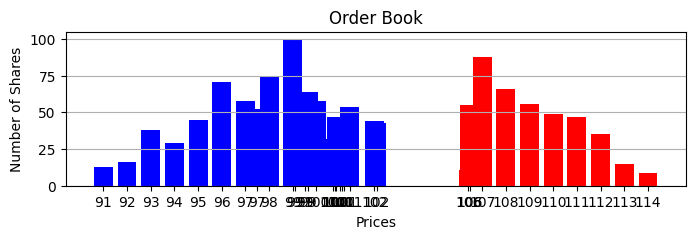

--------------------------------------------------------------------------------


In [4]:
order_book_mp: DynamicOrderBook = DynamicOrderBook(
    p_limit=0.5, 
    p_buy=0.5,
    transition_model=2
)

ob_0 = OrderBook(
    descending_bids=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (100 - x) * 10)
    ) for x in range(100, 90, -1)], 
    ascending_asks=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (x - 105) * 10)
    ) for x in range(105, 115, 1)]
)
init_ob_dist: Distribution[NonTerminal[OrderBook]] = Constant(NonTerminal(ob_0))
dynamic_order_book = order_book_mp.simulate(init_ob_dist)

MAX_ITER = 50
PRINT_INTERVAL = 5
for i in range(MAX_ITER):
    cur_ob = next(dynamic_order_book).state
    if i % PRINT_INTERVAL == 0:
        print(f'Iteration {i}')
        print(f'Bid-ask spread: {cur_ob.bid_ask_spread()}')
        print(f'Market depth: {cur_ob.market_depth()}')
        plt.figure(figsize=(8, 2))
        cur_ob.display_order_book()
        print('-' * 80)

## Question 4
Derive the expressions for the Optimal Value Function and Optimal Policy
for the *Linear-Percentage Temporary* (LPT) Price Impact Model
formulated by Bertsimas and Lo. The LPT model is described below for all
$t = 0, 1, \ldots T-1$:

$$P_{t+1} = P_t \cdot e^{Z_t}$$ 

$$X_{t+1} = \rho \cdot X_t + \eta_t$$

$$Q_t = P_t \cdot (1 - \beta \cdot N_t - \theta \cdot X_t)$$ 

where $Z_t$ are independent and identically distributed random variables with mean
$\mu_Z$ and variance $\sigma^2_Z$ for all $t = 0, 1, \ldots, T-1$,
$\eta_t$ are independent and identically distributed random variables
with mean 0 for all $t = 0, 1, \ldots, T-1$, $Z_t$ and $\eta_t$ are
independent of each other for all $t = 0, 1, \ldots, T-1$, and
$\rho, \beta, \theta$ are given constants. The model assumes no
risk-aversion (Utility function is the identity function) and so, the
objective is to maximize the Expected Total Sales Proceeds over the
finite-horizon up to time $T$ (discount factor is 1). In your
derivation, use the same methodology as we followed for the *Simple
Linear Price Impact Model with no Risk-Aversion*.

Implement this LPT model by customizing the class
`OptimalOrderExecution` in [rl/chapter9/optimal_order_execution.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/optimal_order_execution.py).

Compare the obtained Optimal Value Function and Optimal Policy against
the closed-form solution you derived above.

- Our goal is to compute $V^*_{t}((P_{t}, R_{t})) = \max_{N_t}\mathbb{E}(\sum_{t = 0}^{T-1} \gamma^{t} U(N_t, Q_t))$. Using the identity risk aversion function $U(W) = W$ and $\gamma = 1 $ we obtain
\begin{align*}
    V^*_{t}((P_{t}, R_{t})) &= \max_{N_t}\mathbb{E} \left[ \sum_{t = 0}^{T-1}(N_t \cdot Q_t) \right] \\
    &= \max_{N_t} \left[ {N_t \cdot Q_t + \mathbb{E}[V^*_{t + 1}((P_{t + 1}, R_{t + 1}))]} \right].
\end{align*}

- We are given the distributions for the temporary price impact, the permanent price impact, and the price dynamics. What concerns us now is finding a closed form solution for $V^*_{t}((P_{t}, R_{t}))$ via a recursive relation.  We operate under the assumption that the optimal value function will be zero at the finite end of our MDP; i.e. that $V^*_{T}((P_{T}, R_{T})) = 0$.
- Using backwards induction, we can extend it one step back to the following for the $T - 1$ value function using our bellman equation:
\begin{align*}
    V^*_{T - 1}((P_{T - 1}, R_{T - 1})) &= \max_{N_{T - 1}} \left[ N_{T - 1} \cdot Q_{T - 1} + 0 \right]\\ 
    &= \max_{N_{T - 1}} \left[ N_{T - 1} \cdot P_{T - 1} \cdot (1 - \beta \cdot N_{T - 1} - \theta \cdot X_{T - 1}) \right].
\end{align*}
- The following facts we will use repeatedly: $R_0 = N$; $R_{t + 1} = R_t - N_t$ for all $t < T$; $R_{T - 1} = N_{T - 1} \implies R_T = N_T = 0$; $R_t = N - \sum_{i = 0}^{t - 1}N_i$. So we can rewrite the equation above to become strictly in the time $t$ at each and every step $t$:
\begin{align*}
    V^*_{T - 1}((P_{T - 1}, R_{T - 1})) &= \max_{N_{T-1}} \left[ R_{T - 1} \cdot P_{T - 1} \cdot (1 - \beta \cdot R_{T - 1} - \theta \cdot X_{T - 1}) \right] \\
    &= R_{T - 1} \cdot P_{T - 1} \cdot (1 - \beta \cdot R_{T - 1} - \theta \cdot X_{T - 1}).
\end{align*}

- Then we have
\begin{align*}
    V^*_{T - 2}((P_{T - 2}, R_{T - 2})) &= \max_{N_{T - 2}} \left[ N_{T - 2} \cdot Q_{T - 2} + \mathbb{E}(V^*_{T - 1}((P_{T - 1}, R_{T - 1}))) \right] \\
    &= \max_{N_{T - 2}} [ N_{T - 2} \cdot P_{T - 2} \cdot (1 - \beta \cdot N_{T - 2} - \theta \cdot X_{T - 2}) \\
    &\qquad\qquad+ \mathbb{E}(R_{T - 1} \cdot P_{T - 1} \cdot (1 - \beta \cdot R_{T - 1} - \theta \cdot X_{T - 1})) ] \\
    &= \max_{N_{T - 2}} [N_{T - 2} \cdot P_{T - 2} \cdot (1 - \beta \cdot N_{T - 2} - \theta \cdot X_{T - 2}) \\
    &\qquad\qquad + \mathbb{E}[(R_{T - 2} - N_{T - 2}) \cdot P_{T - 1} \cdot (1 - \beta \cdot R_{T - 1} - \theta \cdot X_{T - 1})] ] \\
    &= \max_{N_{T - 2}} [ N_{T - 2} \cdot P_{T - 2} - \beta N_{T - 2}^2 P_{T - 2} - \theta N_{T - 2} P_{T - 2} X_{T - 2} \\
    &\qquad + (R_{T - 2} - N_{T - 2})\mathbb{E}[P_{T - 2} \cdot e^{Z_{T-2}} (1 - \beta (R_{T - 2} - N_{T - 2}) - \theta(\rho X_{T - 2} + \eta_{T - 2}) )] ] \\
    &= \max_{N_{T - 2}} [ N_{T - 2} \cdot P_{T - 2} - \beta N_{T - 2}^2 P_{T - 2} - \theta N_{T - 2} P_{T - 2} X_{T - 2} \\
    &\qquad + (R_{T - 2} - N_{T - 2})(P_{T - 2} \cdot e^{\mu_z + \frac{1}{2}\sigma_z^2})(1 - \beta (R_{T - 2} - N_{T - 2}) - \theta \rho X_{T - 2}) ]
\end{align*}
using independence of $Z, \eta$. Now, for notational convenience, let $c = e^{\mu_z + \frac{1}{2}\sigma_z^2} $. Then 
\begin{align*}
    V^*_{T - 2}((P_{T - 2}, R_{T - 2})) &= \max_{N_{T - 2}} [ N_{T - 2} \cdot P_{T - 2} - \beta N_{T - 2}^2 P_{T - 2} - \theta N_{T - 2} P_{T - 2} X_{T - 2} \\
    &\qquad + c R_{T-2} P_{T - 2} - \beta c R_{T-2}^2 P_{T - 2} + \beta c R_{T-2} P_{T - 2} N_{T - 2} \\
    &\qquad - \theta c \rho R_{T-2} P_{T - 2}X_{T - 2} - c N_{T-2} P_{T - 2} + \beta c R_{T-2} P_{T - 2} N_{T - 2} \\
    &\qquad - \beta c P_{T - 2} N_{T - 2}^2 + \theta c \rho N_{T - 2}P_{T - 2}X_{T - 2} ] \\
    &= \max_{N_{T - 2}} [ P_{T-2} c [(c^{-1} - 1)N_{T - 2} - \beta (c^{-1} + 1)N_{T - 2}^2 - \theta (c^{-1} - \rho)N_{T - 2} X_{T - 2} + R_{T - 2} \\
    &\qquad - \beta R_{T - 2}^2 + 2\beta R_{T -2}N_{T - 2} - \theta \rho R_{T -2} X_{T - 2} ]].
\end{align*}
- Taking a derivative w.r.t $N_{T - 2}$, and then setting equal to zero for optimality (note since this is concave in $N_{T - 2}^{2}$ and will achieve it's maximum via it's critical point):
\begin{alignat*}{2}
    &\qquad& \frac{d}{dN_{T -2}} V^* &= P_{T - 2}c [ (c^{-1} - 1) - 2\beta (c^{-1} + 1)N_{T - 2} - \theta (c^ {-1} - p)X_{T - 2} + 2\beta R_{T - 2} ] = 0 \\
    \implies&& 2\beta (c^{-1} + 1)N_{T - 2} &= (c^{-1} - 1) - \theta (c^ {-1} - p)X_{T - 2} + 2\beta R_{T - 2} \\
    \implies&& N_{T - 2}^* &= \frac{(c^{-1} - 1) - \theta (c^ {-1} - p)X_{T - 2} + 2\beta R_{T - 2}}{2\beta (c^{-1} + 1)}.
\end{alignat*}

- Hence, we have found our optimal policy at any given time step which is actually indepndent of the price:
\begin{align*}
    N_{t}^* &= \frac{(c^{-1} - 1)}{2\beta (c^{-1} + 1)} - \frac{\theta (c^ {-1} - p)}{2\beta (c^{-1} + 1)}X_{t} + \frac{1}{2\beta (c^{-1} + 1)} R_{t} \\
    &\equiv a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}
\end{align*}
for constants $a_t^1, a_t^2,$ and $a_t^3$.

- Now we can compute the optimal value function at any given time step:
\begin{align*}
    V^*_{t}((P_{t}, R_{t})) &= P_{t}c [(c^{-1} - 1)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) - \beta (c^{-1} + 1)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t})^2 \\
    &\qquad - \theta (c^{-1} - \rho)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) X_{t} + R_{t} - \beta R_{t}^2 \\
    &\qquad + 2\beta R_{t}(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) - \theta \rho R_{t} X_{t} ] \\
    &\equiv P_{t}e^{\mu_z + \frac{1}{2}\sigma_z^2}(a_t^4 +a_t^5 R_t + a_t^6 X_t + a_t^7 (R_t)^2 + a_t^8 (X_t)^2+ a_t^9 R_t X_ t) 
\end{align*}
for constants $a_t^4, a_t^5, a_t^6, a_t^7, a_t^8,$ and $a_t^9$.

In [7]:
class Lognormal(SampledDistribution[float]):
    '''A lognormal distribution with the given μ and σ.'''

    μ: float
    σ: float

    def __init__(self, μ: float, σ: float, expectation_samples: int = 10000):
        self.μ = μ
        self.σ = σ
        super().__init__(
            sampler=lambda: np.random.lognormal(self.μ, self.σ),
            expectation_samples=expectation_samples
        )


@dataclass(frozen=True)
class ApproxOptimalOrderExecution(OptimalOrderExecution):
    num_state_samples: int
    error_tolerance: float

    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                        DeterministicPolicy[PriceAndShares, int]]]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[PriceAndShares, int],
            ValueFunctionApprox[PriceAndShares],
            SampledDistribution[NonTerminal[PriceAndShares]]
        ]] = [(
            self.get_mdp(i),
            self.func_approx,
            self.get_states_distribution(i)
        ) for i in range(self.time_steps)]

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=self.discount_factor,
            num_state_samples=self.num_state_samples,
            error_tolerance=self.error_tolerance
        )

In [8]:
num_shares: int = 100
num_time_steps: int = 5
alpha: float = 0.03
beta: float = 0.05
init_price_mean: float = 100.0
init_price_stdev: float = 10.0

mu_z: float = 0.1
sigma_z = 0.4
rho = 0.9
theta = 0.1

X = np.zeros(num_time_steps)
for i in range(1, num_time_steps):
    X[i] = np.random.normal(rho * X[i-1], 0.3)

price_diff = [lambda p_s: p_s.price * (beta * p_s.shares + theta * X[t]) 
              for t in range(num_time_steps)]
dynamics = [lambda p_s: Lognormal(
    μ=np.log(p_s.price) + mu_z, 
    σ=sigma_z
) for _ in range(num_time_steps)]
ffs = [
    lambda p_s: p_s.state.price * p_s.state.shares,
    lambda p_s: float(p_s.state.shares * p_s.state.shares)
]
fa: FunctionApprox = LinearFunctionApprox.create(feature_functions=ffs)
init_price_distrib: Gaussian = Gaussian(
    μ=init_price_mean,
    σ=init_price_stdev
)

In [9]:
ooe: OptimalOrderExecution = ApproxOptimalOrderExecution(
    shares=num_shares,
    time_steps=num_time_steps,
    avg_exec_price_diff=price_diff,
    price_dynamics=dynamics,
    utility_func=lambda x: x,
    discount_factor=1,
    func_approx=fa,
    initial_price_distribution=init_price_distrib,
    num_state_samples=100,
    error_tolerance=1e-2
)
it_vf: Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                          DeterministicPolicy[PriceAndShares, int]]] = \
        ooe.backward_induction_vf_and_pi()

In [10]:
state: PriceAndShares = PriceAndShares(
    price=init_price_mean,
    shares=num_shares
)
print("Backward Induction: VF And Policy")
print("---------------------------------")
print()
for t, (vf, pol) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()
    opt_sale: int = pol.action_for(state)
    val: float = vf(NonTerminal(state))
    print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
    print()
    print("Optimal Weights below:")
    print(vf.weights.weights)
    print()

Backward Induction: VF And Policy
---------------------------------

Time 0

Optimal Sales = 13, Opt Val = 1305.298

Optimal Weights below:
[ 0.60940755 -0.47887776]

Time 1

Optimal Sales = 10, Opt Val = -1172.902

Optimal Weights below:
[ 0.5291346  -0.64642483]

Time 2

Optimal Sales = 20, Opt Val = -4325.921

Optimal Weights below:
[ 0.42152861 -0.85412068]

Time 3

Optimal Sales = 10, Opt Val = -10606.173

Optimal Weights below:
[ 0.33008334 -1.39070064]

Time 4

Optimal Sales = 13, Opt Val = -32436.112

Optimal Weights below:
[ 0.20675224 -3.4503634 ]



In [16]:
print("Analytical Solution")
print("-------------------")
print()

R = [num_shares]

for t in range(num_time_steps):
    print(f"Time {t:d}")
    print()

    c = np.exp(mu_z + 0.5 * (sigma_z**2))
    a_1 = ((1 / c) - 1) / (2 * beta * ((1 / c) + 1))
    a_2 = (theta * ((1 / c) - rho)) / (2 * beta * ((1 / c) + 1))
    a_3 = 1 / (2 * beta * ((1 / c) + 1))

    N_t_star: float = a_1 - a_2 * X[t] + a_3 * R[t]

    a_4 = ((1 / c) - 1) * a_1 - beta * ((1 / c) + 1) * a_2**2
    a_5 = ((1 / c) - 1) * a_3 - 2 * beta * ((1 / c) + 1) * a_1 * a_3 + 1 + 2 * beta * a_1
    a_6 = ((1 / c) - 1) * a_2 - 2 * beta * ((1 / c) + 1) * a_1 * a_2 - theta * ((1 / c) - rho) * a_1
    a_7 = -beta * ((1 / c) + 1) * a_3**2 - beta + 2 * beta * a_3
    a_8 = -beta * ((1 / c) + 1) * a_2**2 - theta * ((1 / c) - rho) * a_2
    a_9 = -2 * beta * ((1 / c) + 1) * a_2 * a_3 - theta * ((1 / c) - rho) * a_3 + 2 * beta * a_2 - theta * rho

    V_t_star: float = state.shares * np.exp(mu_z + 0.5 * sigma_z**2) * (a_4 + a_5 * R[t] + a_6 * X[t] + a_7 * R[t]**2 + a_8 * X[t]**2 + a_9 * R[t] * X[t])

    print(f"Optimal Sales = {N_t_star:.3f}, Opt Val = {V_t_star:.3f}")
    # print(f"Weight1 = {wt1:.3f}")
    # print(f"Weight2 = {wt2:.3f}")
    print()

    R.append(R[t] - N_t_star)

Analytical Solution
-------------------

Time 0

Optimal Sales = 543.981, Opt Val = -2658299.485

Time 1

Optimal Sales = -2420.054, Opt Val = -52663625.997

Time 2

Optimal Sales = 10766.311, Opt Val = -1042077277.030

Time 3

Optimal Sales = -47897.019, Opt Val = -20625501913.062

Time 4

Optimal Sales = 213083.726, Opt Val = -408209600550.756



- Hence, we have found our optimal policy at any given time step which is actually indepndent of the price:
\begin{align*}
    N_{t}^* &= \frac{(c^{-1} - 1)}{2\beta (c^{-1} + 1)} - \frac{\theta (c^ {-1} - p)}{2\beta (c^{-1} + 1)}X_{t} + \frac{1}{2\beta (c^{-1} + 1)} R_{t} \\
    &\equiv a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}
\end{align*}
for constants $a_t^1, a_t^2,$ and $a_t^3$.

- Now we can compute the optimal value function at any given time step:
\begin{align*}
    V^*_{t}((P_{t}, R_{t})) &= P_{t}c [(c^{-1} - 1)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) - \beta (c^{-1} + 1)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t})^2 \\
    &\qquad - \theta (c^{-1} - \rho)(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) X_{t} + R_{t} - \beta R_{t}^2 \\
    &\qquad + 2\beta R_{t}(a_t^1 + a_t^2 X_{t} + a_t^3 R_{t}) - \theta \rho R_{t} X_{t} ] \\
    &\equiv P_{t}e^{\mu_z + \frac{1}{2}\sigma_z^2}(a_t^4 +a_t^5 R_t + a_t^6 X_t + a_t^7 (R_t)^2 + a_t^8 (X_t)^2+ a_t^9 R_t X_ t) 
\end{align*}
for constants $a_t^4, a_t^5, a_t^6, a_t^7, a_t^8,$ and $a_t^9$.

In [12]:
# R = num_shares #to keep track of remaining shares
# for t in range(num_time_steps):
#     print(f"Time {t:d}")
#     c = np.exp(mu_z + 0.5 * (sigma_z**2))
#     a_1 = ((1/c) - 1)/(2*beta*((1/c) + 1))
#     a_2 = (theta*((1/c) - rho))/(2*beta*((1/c) + 1))
#     a_3 = 1/(2*beta*((1/c) + 1))
#     N_t = a_1 - a_2*x[t] + a_3*R
#     optimal_value = state.price*c #need to properly fix this
#     R -= N_t